Students:
- Abdel Kader, Schehat
- Lushaj, Detijon


## Single-Cell RNA-Seq Analysis Project

Choose one of the following tasks:

**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.

**We choose Exploratory Data Analysis and Visualization**

## Imports

In [1]:
!pip install umap-learn
!pip install scanpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load Dataset

- Norman dataset is a perturbation dataset used in single-cell RNA sequencing studies. Contains data on how different conditions (perturbations) affect gene expression in individual cells

In [2]:
import pertdata as pt # noqa: E402

# Load the Norman dataset
norman = pt.PertData.from_repo(name="norman", save_dir="data")

Dataset directory already exists: data\norman
Loading dataset: norman


- The perturbation data is stored in an [`AnnData`](https://anndata.readthedocs.io/en/latest/) object.
- We have $n$ observations with $d$-dimensional vector corresponding to features
- In scRNA-seq data, each row corresponds to a cell and each column corresponds to a gene

- AnnData Object Properties:
 - X: main data matrix
 - obs: Observation metadata for each cell
   - control: indicates if the cell is from a control group, baseline for comparisons
   - condition_name: the name of the condition/treatment applied to the cell
 - var: Variables metadata for each gene

In [3]:
print("Dataset Information:")
print(norman)
print("\nAnnData Object Details:")
print(norman.adata)

Dataset Information:
PertData object
    name: norman
    path: data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045

AnnData Object Details:
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'


## Explore data

In [4]:
X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]

print(f"X.shape: (number of cells, number of genes) = {X.shape}")  # type: ignore
print(f"y_pert.shap: (number of cells) = {y_pert.shape}")
print(f"y_ctrl.shape: (number of cells) = {y_ctrl.shape}")
print(f"gene_names.shape: (number of genes) = {gene_names.shape}")

X.shape: (number of cells, number of genes) = (91205, 5045)
y_pert.shap: (number of cells) = (91205,)
y_ctrl.shape: (number of cells) = (91205,)
gene_names.shape: (number of genes) = (5045,)


In [5]:
unique_conditions = norman.adata.obs['condition_fixed'].unique()
print(f"Number of unique fixed conditions: {len(unique_conditions)}")

num_control_cells = norman.adata.obs['control'].sum()
print(f"Number of control cells: {num_control_cells}")

# Check the total number of cells
total_cells = norman.adata.n_obs
print(f"Number of pertubated cells: {total_cells - num_control_cells}")

Number of unique fixed conditions: 237
Number of control cells: 7353
Number of pertubated cells: 83852


statistics for gene expression

In [6]:
# Convert X to a dense NumPy array if it's sparse
X_dense = X.toarray() if hasattr(X, 'toarray') else X

summary_stats = pd.DataFrame({
    'Mean': np.mean(X_dense, axis=0),
    'Median': np.median(X_dense, axis=0),
    'Std': np.std(X_dense, axis=0)
}, index=gene_names)

print(summary_stats.describe())

              Mean       Median          Std
count  5045.000000  5045.000000  5045.000000
mean      0.107437     0.082423     0.111424
std       0.399396     0.406906     0.173630
min       0.000010     0.000000     0.003045
25%       0.000101     0.000000     0.009794
50%       0.000767     0.000000     0.026184
75%       0.017414     0.000000     0.122793
max       5.187199     5.184844     1.450067


In the dataset are all instances from the A549 cell. A549 cells are used to test the effects of various drugs and treatments on lung cancer cell  

In [7]:
cell_type_counts = norman.adata.obs['cell_type']
print(cell_type_counts.value_counts())

cell_type
A549    91205
Name: count, dtype: int64


# Data preprocessing

Filtering out double-gene perturbations

In [8]:
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()

Look at the new data

In [9]:
print(adata_single)
print("\nNumber of conditions after filtering:")
print(adata_single.obs["condition_fixed"].value_counts())

AnnData object with n_obs × n_vars = 55760 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

Number of conditions after filtering:
condition_fixed
ctrl      7353
KLF1      1641
BAK1      1171
CEBPE     1039
ETS2      1031
          ... 
NIT1       165
CDKN1C     165
ZBTB10     145
HES7       122
PLK4        97
Name: count, Length: 106, dtype: int64


## PCA

Convert sparse matrix to dense and normalize data

In [10]:
X = adata_single.X.toarray()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Apply PCA

In [11]:
n_components = 128
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

Plot explained variance ratio

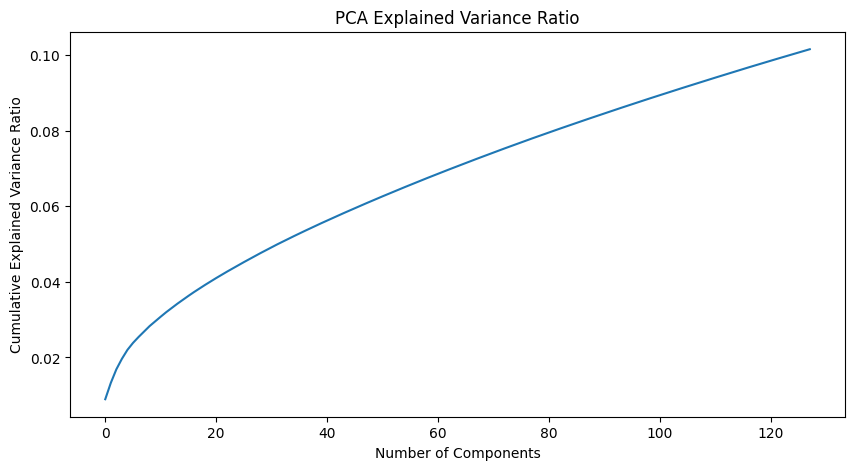

Cumulative Explained Variance Ratio: 0.10


In [12]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

print(f"Cumulative Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.2f}")

In [13]:
explained_variance_ratio = pca.explained_variance_ratio_[:2]
print(f"Explained Variance Ratio for the first 2 components: {explained_variance_ratio}")
print(f"sum: {np.sum(explained_variance_ratio)}")

Explained Variance Ratio for the first 2 components: [0.0089523  0.00431182]
sum: 0.013264119625091553


Each point represents a cell, and the points are colored by their condition

C:\Users\SAbde\AppData\Local\Temp\ipykernel_24208\3153212625.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


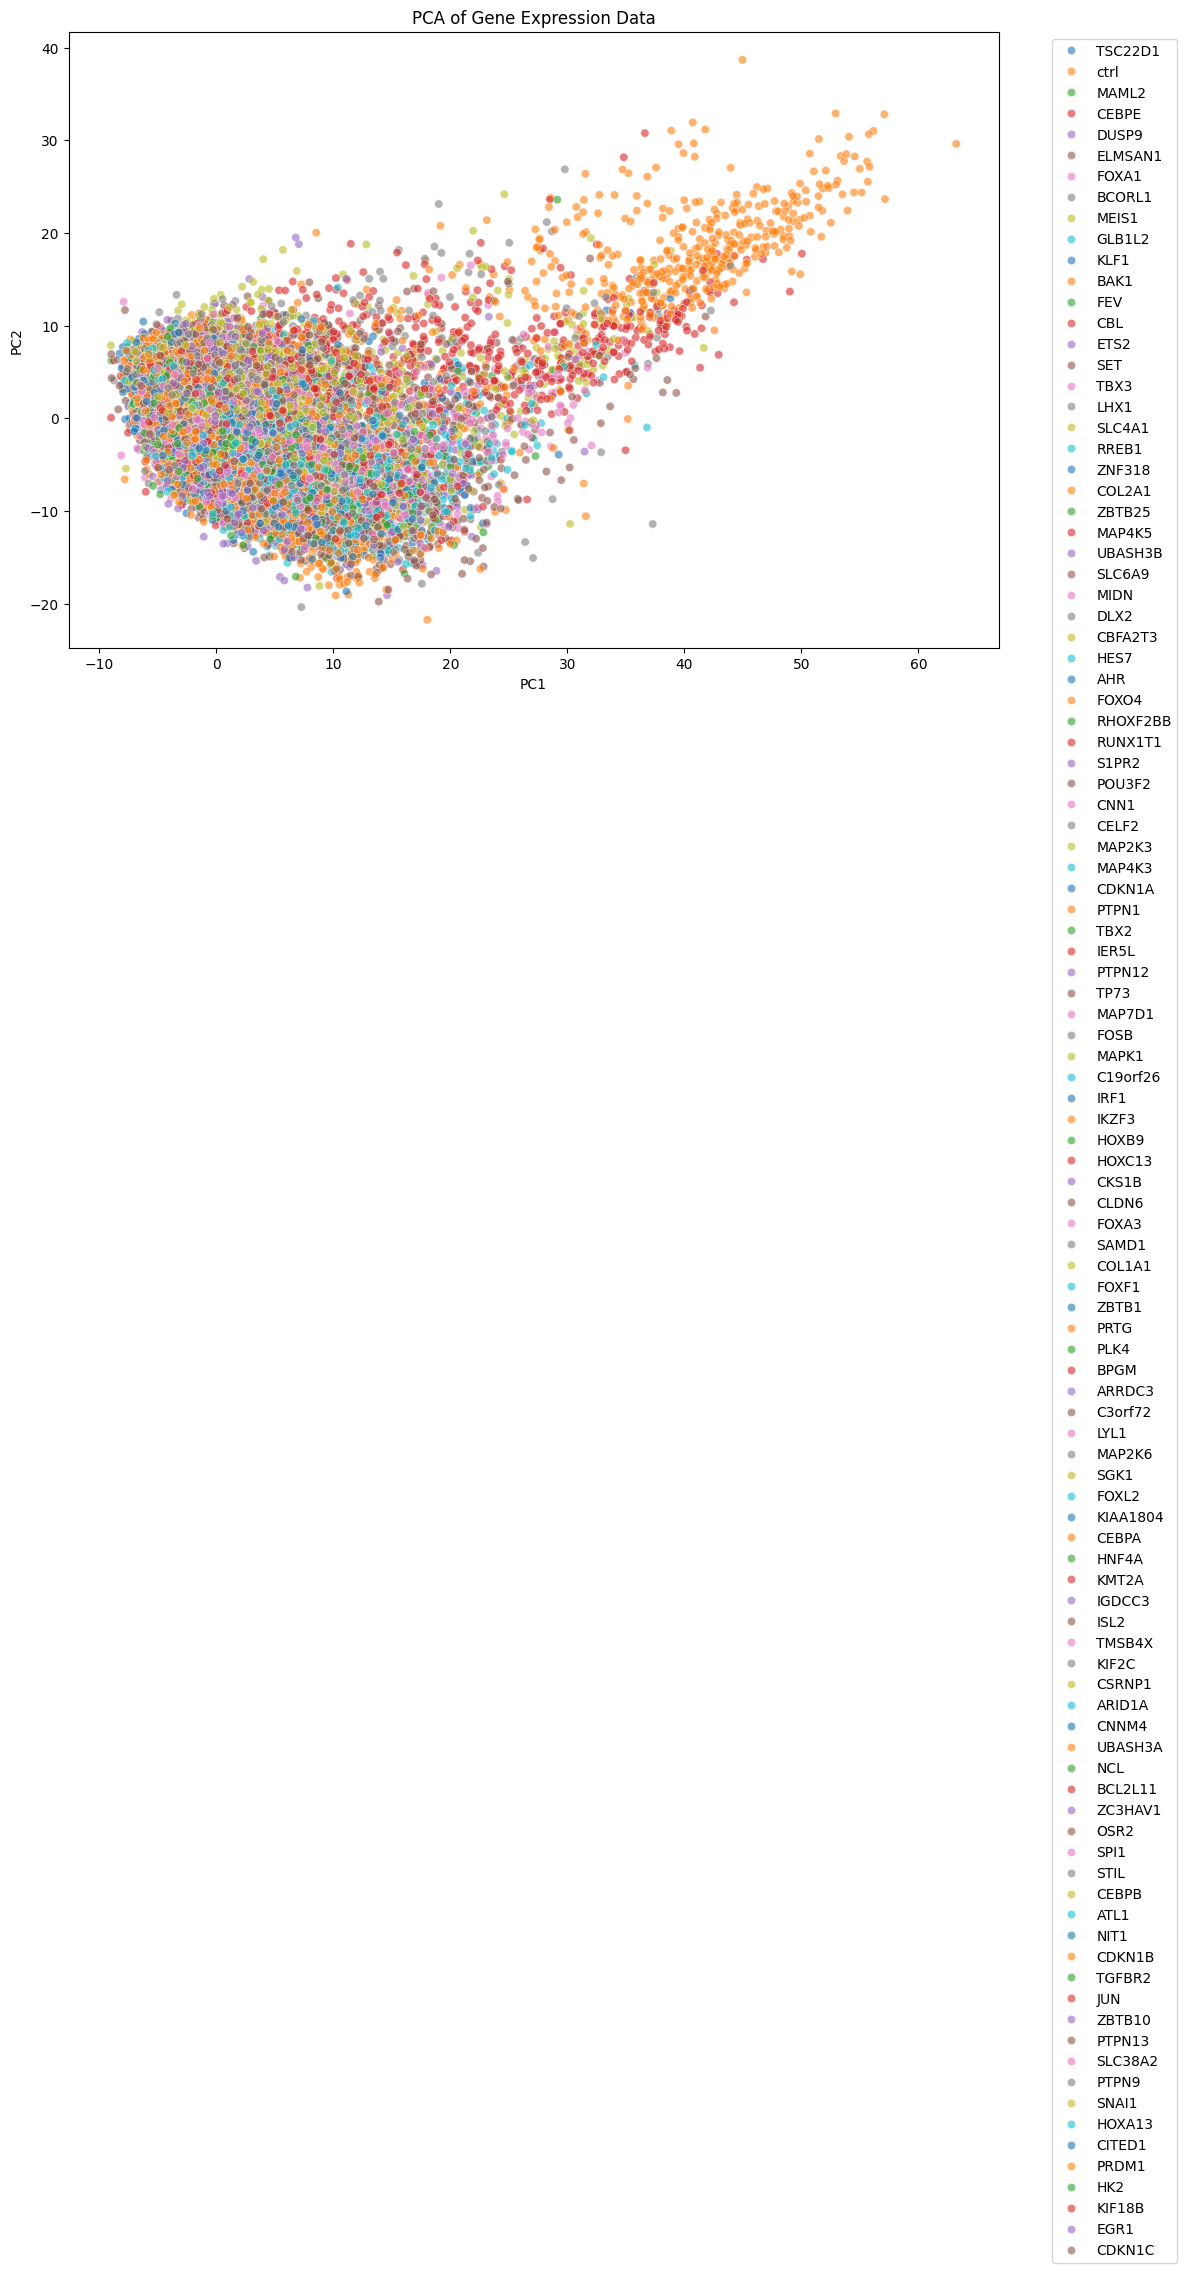

In [14]:
# Create a DataFrame for the first two principal components
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['Condition'] = adata_single.obs['condition_fixed'].values

# Plot the first two principal components
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Condition', alpha=0.6, palette='tab10')
plt.title('PCA of Gene Expression Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

PCA with all components

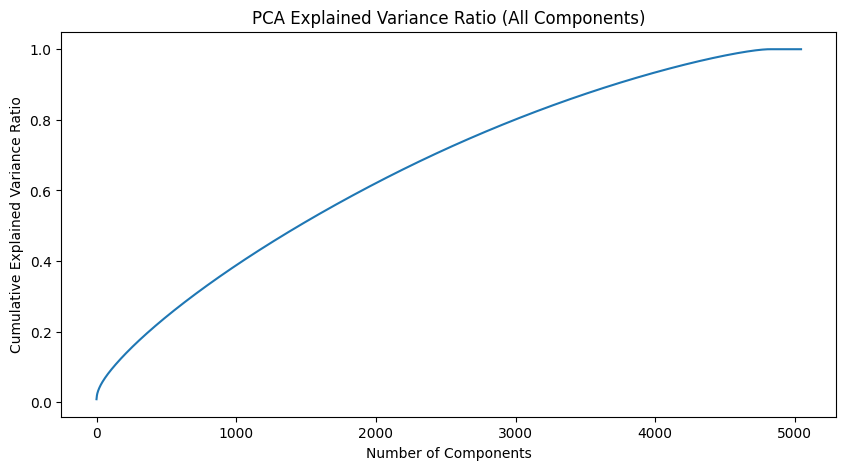

In [27]:
# Perform PCA with all components
pca_all = PCA(n_components=None)
X_pca_all = pca_all.fit_transform(X_scaled)

# Plot explained variance ratio for all components
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio (All Components)')
plt.show()

## Clustering

c:\Users\SAbde\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\SAbde\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\SAbde\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\SAbde\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

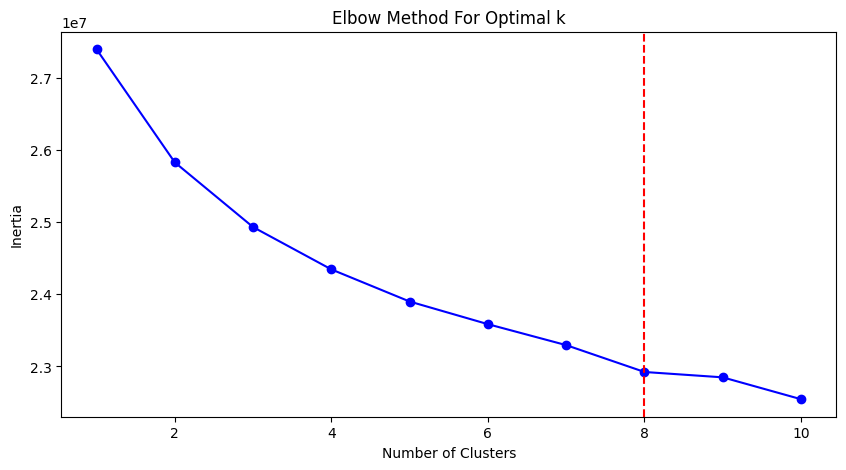

In [21]:
from sklearn.cluster import KMeans

# Determine the best number of clusters using the elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Calculate the second derivative of the inertia to find the elbow point
second_derivative = np.diff(inertia, 2)
best_k = np.argmin(second_derivative) + 1  # 12 because np.diff reduces the original index by 1

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=best_k, color='r', linestyle='--')
plt.show()

c:\Users\SAbde\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Chosen number of clusters: 8


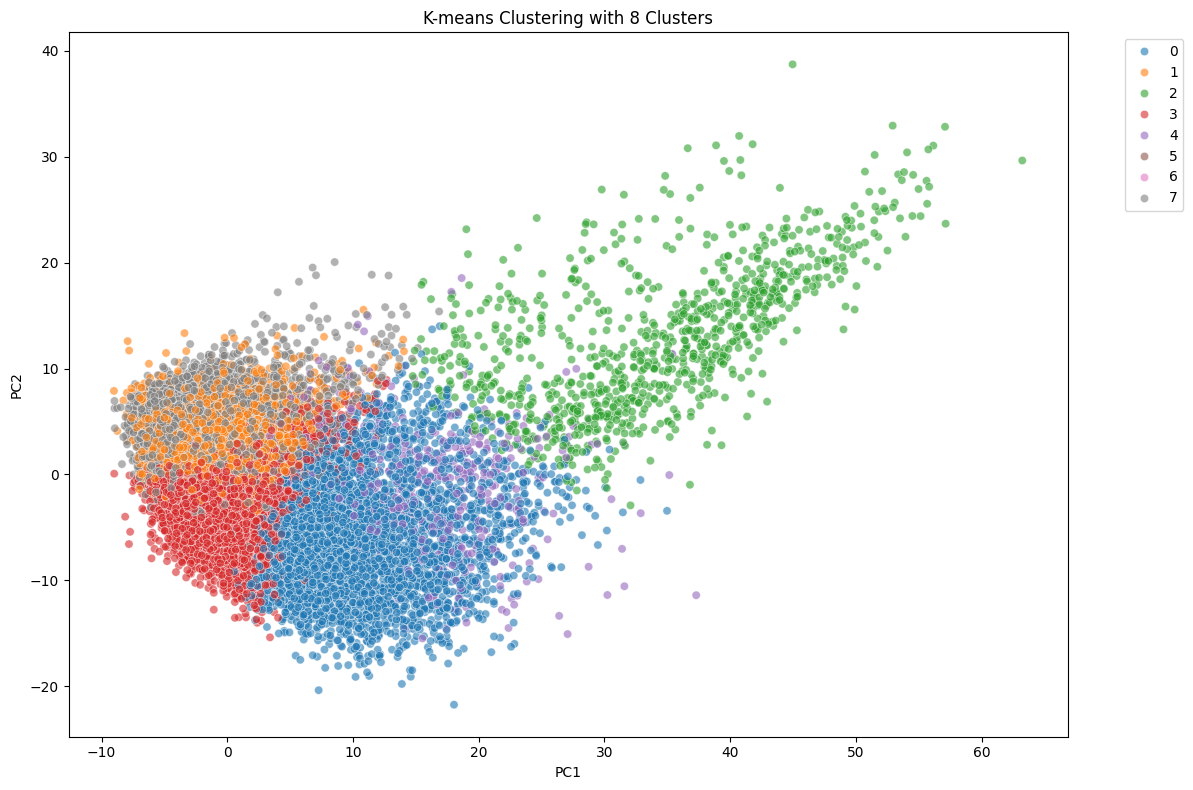

In [22]:
# Perform K-means clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_pca)
# Print the chosen number of clusters
print(f"Chosen number of clusters: {best_k}")

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.6)
plt.title(f'K-means Clustering with {best_k} Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
# Cluster Size and Distribution
cluster_sizes = pca_df['Cluster'].value_counts()
print(cluster_sizes)

Cluster
3    21409
1    14651
7    12903
0     5382
2      947
4      466
5        1
6        1
Name: count, dtype: int64


In [24]:
# Add cluster labels to the adata_single.obs DataFrame
adata_single.obs['Cluster'] = clusters

# Get the control cells
control_cells = adata_single[adata_single.obs['condition_fixed'] == 'ctrl']

# Calculate mean expression for control cells
control_mean_expression = control_cells.X.mean(axis=0).A1 if hasattr(control_cells.X.mean(axis=0), 'A1') else control_cells.X.mean(axis=0)

for cluster in range(kmeans.n_clusters):
    cluster_cells = adata_single[(adata_single.obs['Cluster'] == cluster) & (adata_single.obs['condition_fixed'] != 'ctrl')]
    
    if cluster_cells.shape[0] > 1:  # Check if the size of the cluster is greater than 1
        mean_expression = cluster_cells.X.mean(axis=0).A1 if hasattr(cluster_cells.X.mean(axis=0), 'A1') else cluster_cells.X.mean(axis=0)
        
        # Get the indices of the highest and lowest mean expressions
        highest_idx = np.argsort(mean_expression)[-1]
        lowest_idx = np.argsort(mean_expression)[0]
        
        highest_gene = adata_single.var['gene_name'].iloc[highest_idx]
        lowest_gene = adata_single.var['gene_name'].iloc[lowest_idx]
        
        # Determine the condition/perturbation causing the highest and lowest expression
        highest_condition = cluster_cells.obs['condition_fixed'].value_counts().idxmax()
        lowest_condition = cluster_cells.obs['condition_fixed'].value_counts().idxmin()
        
        highest_expression = mean_expression[highest_idx]
        lowest_expression = mean_expression[lowest_idx]
        
        control_highest_expression = control_mean_expression[highest_idx]
        control_lowest_expression = control_mean_expression[lowest_idx]
        
        highest_diff = highest_expression - control_highest_expression
        lowest_diff = lowest_expression - control_lowest_expression
        
        print(f"Cluster {cluster} highest expression gene: {highest_gene} ({highest_expression}) caused by: {highest_condition} => difference with control: {highest_diff}")
        print(f"Cluster {cluster} lowest expression gene: {lowest_gene} ({lowest_expression}) caused by: {lowest_condition} => difference with control: {lowest_diff}")

Cluster 0 highest expression gene: MALAT1 (6.027583122253418) caused by: IKZF3 => difference with control: 1.1192150115966797
Cluster 0 lowest expression gene: RP11-34P13.8 (0.0) caused by: MAP2K3 => difference with control: 0.0
Cluster 1 highest expression gene: MT-CO3 (5.015610218048096) caused by: KLF1 => difference with control: -0.12828445434570312
Cluster 1 lowest expression gene: TLR4 (0.0) caused by: HOXA13 => difference with control: -0.00010677373938960955
Cluster 2 highest expression gene: MALAT1 (6.145326614379883) caused by: CEBPA => difference with control: 1.2369585037231445
Cluster 2 lowest expression gene: AC023491.2 (0.0) caused by: LYL1 => difference with control: 0.0
Cluster 3 highest expression gene: MT-CO3 (5.307986736297607) caused by: SET => difference with control: 0.1640920639038086
Cluster 3 lowest expression gene: AC023491.2 (0.0) caused by: HES7 => difference with control: 0.0
Cluster 4 highest expression gene: MALAT1 (7.004938125610352) caused by: OSR2 => 

In [28]:
# Exclude control condition from the analysis
adata_non_ctrl = adata_single[adata_single.obs['condition_fixed'] != 'ctrl']

# Calculate mean expression for each gene in each cluster
cluster_mean_expression = adata_non_ctrl.to_df().groupby(adata_non_ctrl.obs['Cluster']).mean()

# Calculate variance in expression for each gene in each cluster
cluster_variance_expression = adata_non_ctrl.to_df().groupby(adata_non_ctrl.obs['Cluster']).var()

# Find the gene with the highest variance in expression for each cluster
for cluster in cluster_variance_expression.index:
    variance_expression = cluster_variance_expression.loc[cluster]
    
    # Skip clusters with no data (NaN values)
    if variance_expression.isna().all():
        continue
    
    highest_variance_idx = variance_expression.idxmax()
    highest_variance_gene = adata_non_ctrl.var.loc[highest_variance_idx, 'gene_name']
    
    # Determine the condition/perturbation causing the highest variance in expression
    cluster_cells = adata_non_ctrl[adata_non_ctrl.obs['Cluster'] == cluster]
    highest_variance_condition = cluster_cells.obs.loc[:, 'condition_fixed'].value_counts().idxmax()
    
    # Calculate the difference in mean expression between the cluster and control cells
    mean_expression_cluster = cluster_mean_expression.loc[cluster, highest_variance_idx]
    mean_expression_control = control_mean_expression[adata_non_ctrl.var.index.get_loc(highest_variance_idx)]
    expression_difference = mean_expression_cluster - mean_expression_control
    
    print(f"Cluster {cluster} highest variance gene: {highest_variance_gene} caused by condition: {highest_variance_condition} => difference with control: {expression_difference:.2f}")

Cluster 0 highest variance gene: HBZ caused by condition: IKZF3 => difference with control: 0.51
Cluster 1 highest variance gene: HBZ caused by condition: KLF1 => difference with control: 0.32
Cluster 2 highest variance gene: CLC caused by condition: CEBPA => difference with control: 1.60
Cluster 3 highest variance gene: HBZ caused by condition: SET => difference with control: 0.45
Cluster 4 highest variance gene: GDF15 caused by condition: OSR2 => difference with control: 1.33
Cluster 7 highest variance gene: HIST1H4C caused by condition: KLF1 => difference with control: -0.58


The three most differentially expressed genes across all clusters are:
PLCG2
MT-ATP6
TMSB4X
Expression values across clusters for the top 3 genes:
gene_id  ENSG00000197943  ENSG00000198899  ENSG00000205542
Cluster                                                   
0               0.165460         3.960857         3.409213
1               0.121861         3.971746         3.401010
2               0.252982         4.045336         4.844728
3               0.141390         4.212440         3.335438
4               0.228855         3.689751         3.089970
5               8.042578         0.000000         2.541333
6               0.000000         1.398614         0.000000
7               0.153275         3.990964         3.350262


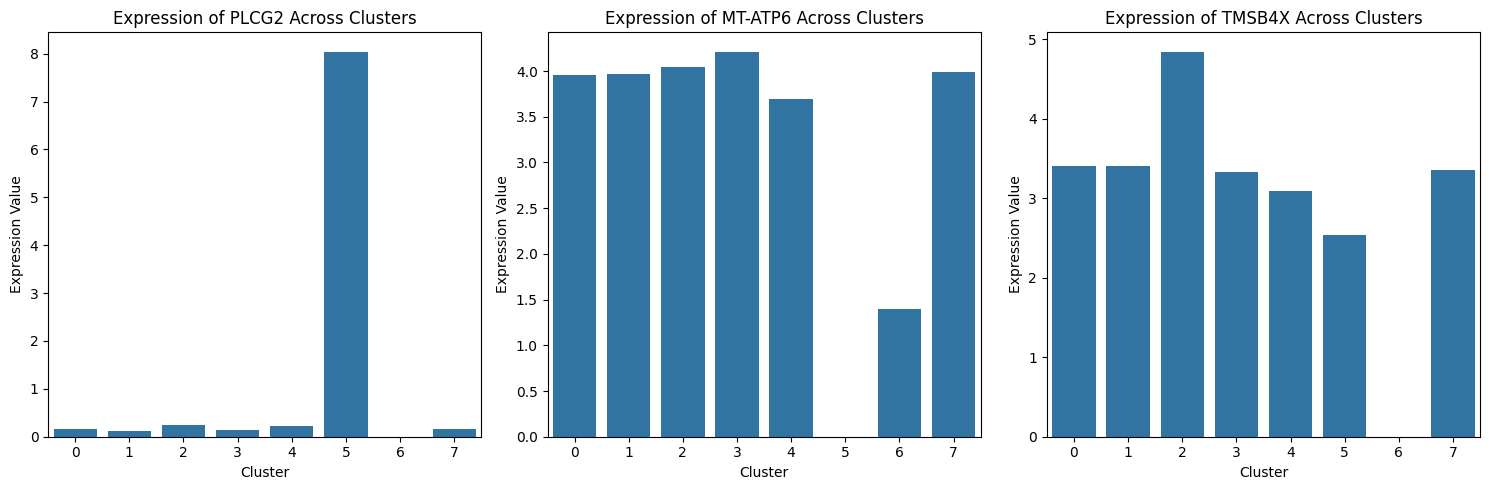

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean expression for each gene in each cluster
cluster_mean_expression = adata_single.to_df().groupby(adata_single.obs['Cluster']).mean()

# Calculate variance in expression for each gene across clusters
gene_variance_across_clusters = cluster_mean_expression.var(axis=0)

# Find the three genes with the highest variance in expression across clusters
top_3_genes = gene_variance_across_clusters.nlargest(3).index
top_3_gene_names = adata_single.var.loc[top_3_genes, 'gene_name']

print("The three most differentially expressed genes across all clusters are:")
for gene in top_3_gene_names:
    print(gene)

# Get the expression values of the top 3 differentially expressed genes across clusters
expression_values_top_3 = cluster_mean_expression[top_3_genes]

print("Expression values across clusters for the top 3 genes:")
print(expression_values_top_3)

# Plot separate bar plots for each gene
plt.figure(figsize=(15, 5))
for i, gene in enumerate(top_3_genes):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=expression_values_top_3.index, y=expression_values_top_3[gene])
    plt.xlabel('Cluster')
    plt.ylabel('Expression Value')
    plt.title(f'Expression of {adata_single.var.loc[gene, "gene_name"]} Across Clusters')
plt.tight_layout()
plt.show()

In [30]:
# Print the condition for cluster 5
cluster_5_condition = adata_single.obs[adata_single.obs['Cluster'] == 5]['condition_fixed']
print(f"Condition for cluster 5: {cluster_5_condition.values[0]}")

# Print the condition for cluster 6
cluster_6_condition = adata_single.obs[adata_single.obs['Cluster'] == 6]['condition_fixed']
print(f"Condition for cluster 6: {cluster_6_condition.values[0]}")

Condition for cluster 5: TBX2
Condition for cluster 6: ctrl


#  Visualize gene expression profiles across different conditions and perturbations

C:\Users\SAbde\AppData\Local\Temp\ipykernel_23976\2985367362.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=7)
C:\Users\SAbde\AppData\Local\Temp\ipykernel_23976\2985367362.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=7)
C:\Users\SAbde\AppData\Local\Temp\ipykernel_23976\2985367362.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=7)


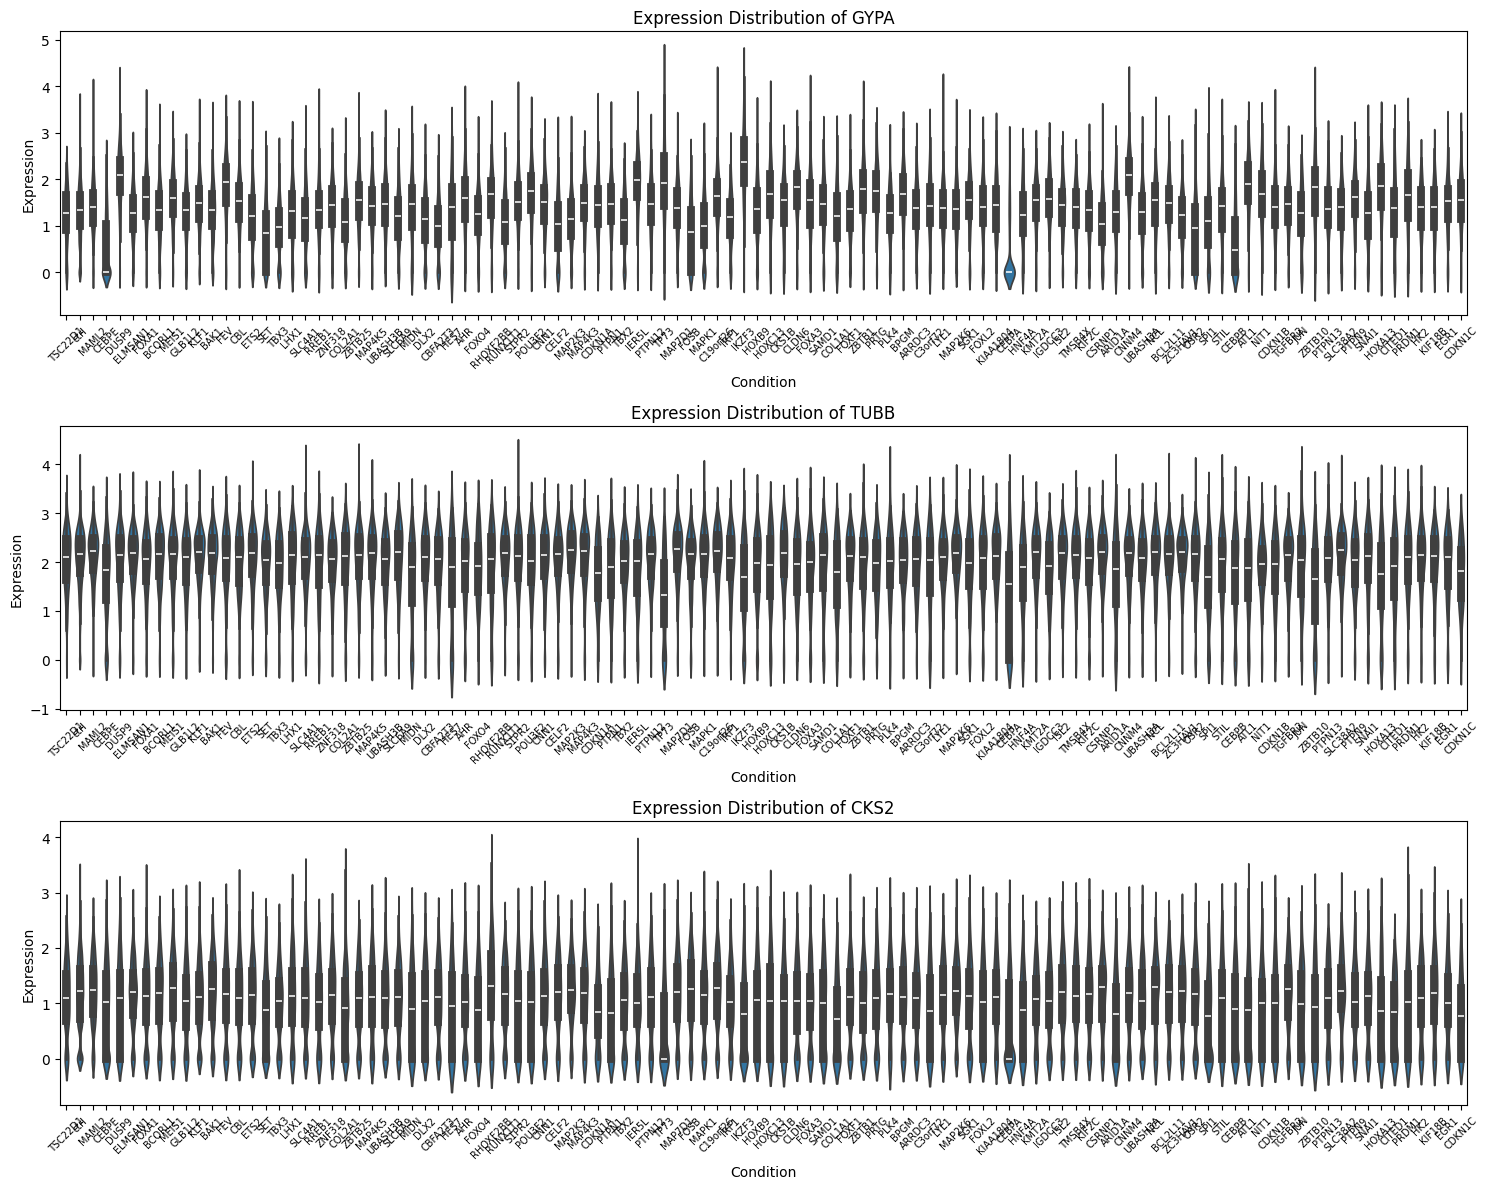

In [26]:
# Select top variable genes for heatmap
n_top_genes = 25
gene_vars = np.var(X, axis=0)
top_gene_idx = np.argsort(gene_vars)[-n_top_genes:]
top_genes = adata_single.var['gene_name'].iloc[top_gene_idx]

# Create violin plots for top genes
n_genes_to_plot = 3
selected_genes = top_genes[:n_genes_to_plot]
selected_gene_idx = top_gene_idx[:n_genes_to_plot]

# Plot violin plots
fig, axes = plt.subplots(n_genes_to_plot, 1, figsize=(15, 4*n_genes_to_plot))

for i, (gene, idx) in enumerate(zip(selected_genes, selected_gene_idx)):
    expr_data = pd.DataFrame({
        'Expression': X[:, idx],
        'Condition': adata_single.obs['condition_fixed']
    })
    sns.violinplot(data=expr_data, x='Condition', y='Expression', ax=axes[i])
    axes[i].set_title(f'Expression Distribution of {gene}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=7)

plt.tight_layout()
plt.show()

# Create heatmaps of the top differentially expressed genes

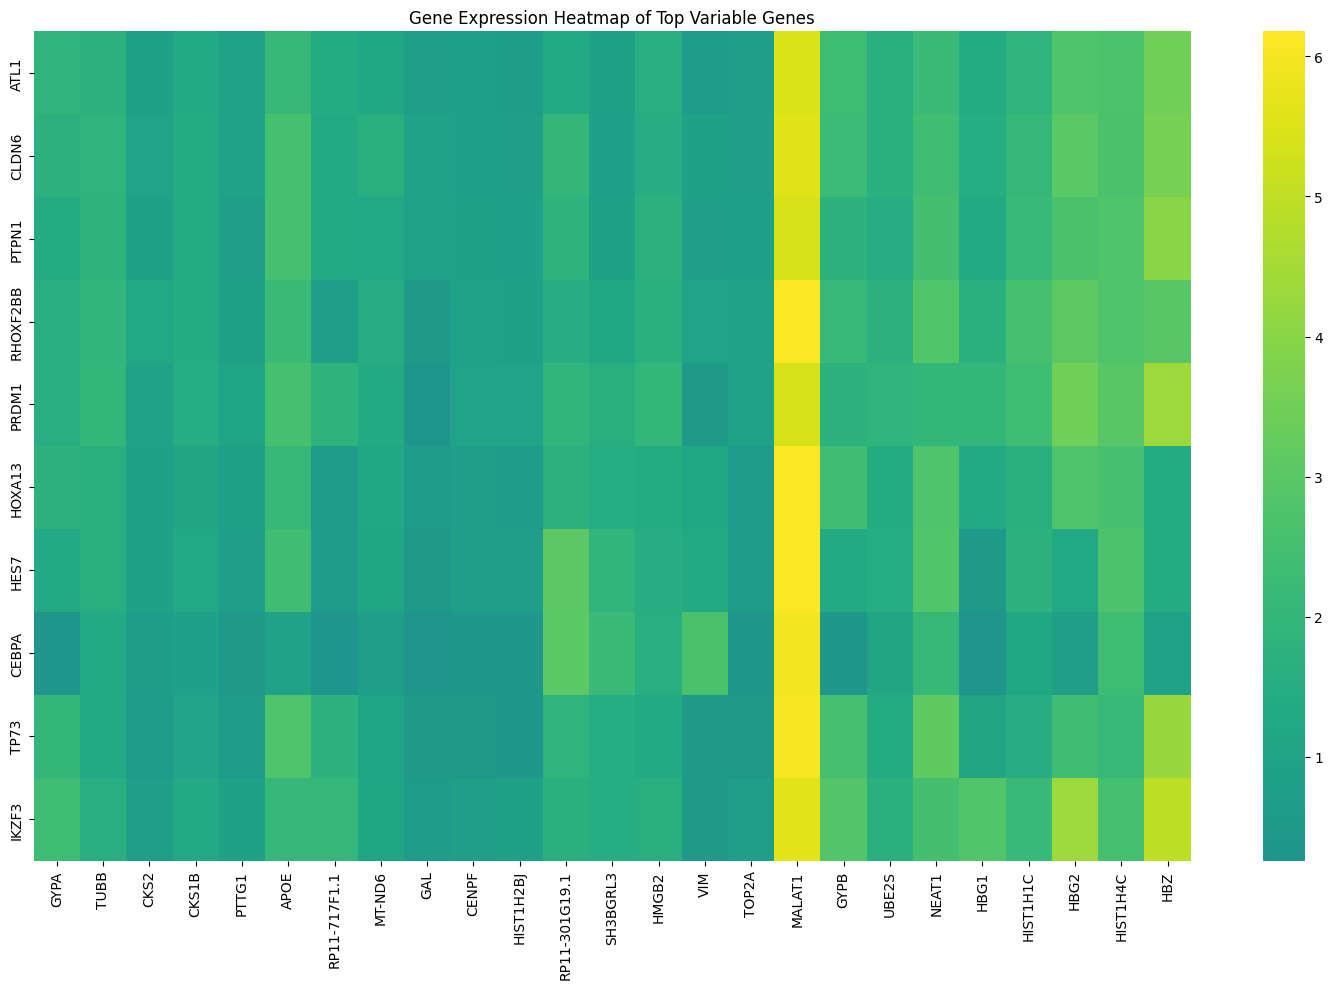

In [21]:
# Calculate mean expression per condition for top genes
conditions = adata_single.obs['condition_fixed'].unique()
mean_expr = np.zeros((len(conditions), n_top_genes))

for i, cond in enumerate(conditions):
    mask = adata_single.obs['condition_fixed'] == cond
    mean_expr[i] = np.mean(X[mask][:, top_gene_idx], axis=0)

# Create heatmap
plt.figure(figsize=(15, 10))
# Select conditions with the highest variance
n_conditions_to_plot = 10
condition_variances = np.var(mean_expr, axis=1)
top_condition_idx = np.argsort(condition_variances)[-n_conditions_to_plot:]
top_conditions = conditions[top_condition_idx]
mean_expr_top_conditions = mean_expr[top_condition_idx]

sns.heatmap(mean_expr_top_conditions,
            xticklabels=top_genes,
            yticklabels=top_conditions,
            cmap='viridis',
            center=0)
plt.title('Gene Expression Heatmap of Top Variable Genes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()